## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 1: Naive Bayes
### Total Points: 100 points

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [1]:
import numpy as np
import math
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import random as rand
warnings.filterwarnings("ignore")

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [2]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("movie_reviews-1.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [3]:
# print head of data frame with help of head function
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

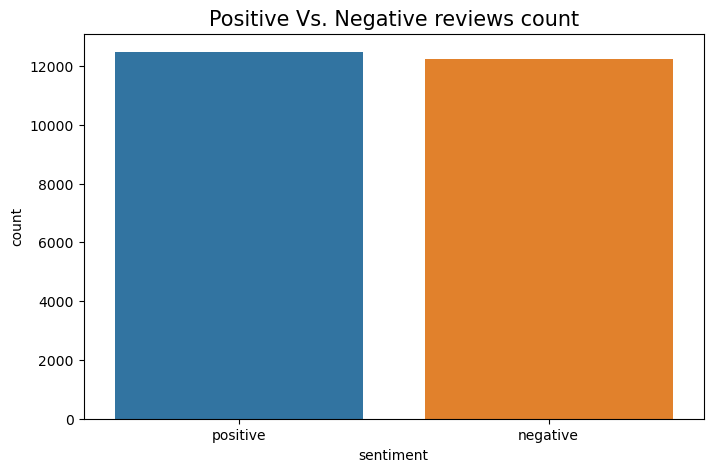

In [4]:
plt.figure(figsize = (8,5))
sns.countplot(df, x = 'sentiment')
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()

## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [5]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df.sentiment == 'positive']
df_minority = df[df.sentiment == 'negative']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [6]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
df_upsampled[df_upsampled.sentiment == 'negative'].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [7]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
df_upsampled[df_upsampled.sentiment == 'positive'].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [8]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([negative_data_points_train['review'], positive_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([negative_data_points_train['sentiment'], positive_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
X_test = pd.concat([negative_data_points_test['review'], positive_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([negative_data_points_test['sentiment'], positive_data_points_test['sentiment']])


In [9]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
y_train.value_counts()

negative    10000
positive    10000
Name: sentiment, dtype: int64

### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [10]:
y_test.value_counts()

negative    2474
positive    2474
Name: sentiment, dtype: int64

### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [11]:
# TASK CELL

# Get the English stop words
stop_words = set(stopwords.words('english'))

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 
    '''

    # Lowercase the review
    review = review.lower()

    # Remove links
    review = re.sub(r"http\S+|www\S+|https\S+", '', review, flags=re.MULTILINE)

    # Remove punctuations
    review = review.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the review
    tokens = word_tokenize(review)

    # Remove stopwords and perform lemmatization
    review_cleaned = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # review_cleaned = [porter.stem(token) for token in tokens if token not in stop_words]

    # Join the cleaned tokens back into a string
    review_cleaned = ' '.join(review_cleaned)

    return review_cleaned

## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [12]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    pair = (word, label)
    n = frequency.get(pair, 0)
    
    return n

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [13]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [14]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

1    10000
0    10000
Name: sentiment, dtype: int64

In [15]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'"Masters of Horror" has proved itself a poor arena for \'message episodes,\' and while a definite case can be made for Joe Dante\'s \'Screwfly Solution\' (one of the best episodes of the series, period), most efforts to do so have come across as anvil-heavy and unimpressive (nothing defuses horror more than a soapbox). And \'Pro-Life\' simply fuses reactionary viewpoints with ultra-violence; young Angelique (Caitlin Wachs), seen running through the woods, is nearly hit by 2 doctors (Mark Feuerstein and Emmanuelle Vaugier) who just happen to be driving in to work at the local (and isolated) abortion clinic. Angelique\'s father, Dwayne (Ron Perlman), is a stone-cold, far-right holy roller who will do anything to prevent his daughter from getting an abortion. If for nothing else, \'Pro-Life\' accumulated some buzz for its controversial issue, but John Carpenter treats this whole venture with startling indifference--he seems even less interested in making a movie than the script itself (w

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [16]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

master horror proved poor arena message episode definite case made joe dante screwfly solution one best episode series period effort come across anvilheavy unimpressive nothing defuses horror soapbox prolife simply fuse reactionary viewpoint ultraviolence young angelique caitlin wachs seen running wood nearly hit 2 doctor mark feuerstein emmanuelle vaugier happen driving work local isolated abortion clinic angelique father dwayne ron perlman stonecold farright holy roller anything prevent daughter getting abortion nothing else prolife accumulated buzz controversial issue john carpenter treat whole venture startling indifferencehe seems even le interested making movie script admittedly poor slow pacing build tension simply brings already ambling plot crawl even dwayne son storm clinic gun blazing stunning nonevent later doctor tortured male abortion scene come gratuitous unnecessaryan effort pad underwritten film poor performance perlman sadly wasted become outgrowth script carpenter di

We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [17]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, review in zip(positive_or_negative, reviews):
      split_review = clean_review(review).split()
      for word in split_review:
        key = (word, label)

        if key in output_occurrence:
            output_occurrence[key] += 1
        else:
            output_occurrence[key] = 1
   
    return output_occurrence

### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [18]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bored', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movie', 0): 2,
 ('fantastic', 0): 1,
 ('watch', 1): 1,
 ('complete', 1): 1,
 ('waste', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoyed', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [19]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [20]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
list(freqs)[0:10]

[('master', 1),
 ('horror', 1),
 ('proved', 1),
 ('poor', 1),
 ('arena', 1),
 ('message', 1),
 ('episode', 1),
 ('definite', 1),
 ('case', 1),
 ('made', 1)]

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [21]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = len(train_y)

    # Calculate D_pos, the number of positive documents 
    D_pos = sum(train_y)

    # Calculate D_neg, the number of negative documents 
    D_neg = num_doc - D_pos

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 1)
        freq_neg = find_occurrence(freqs, word, 0)
        
        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (num_pos + V)
        p_w_neg = (freq_neg + 1) / (num_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)


    return logprior, loglikelihood

In [22]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
91915


### Expected Output 

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [23]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    # process the review to get a list of words
    word_l = clean_review(review).split()

    # initialize probability to zero
    total_prob = 0
    
    # add the logprior
    total_prob += logprior

    for word in word_l:
        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]

    # classify as 1 (negative) if total_prob >= 0, else 0 (positive)
    return 1 if total_prob >= 0 else 0

In [24]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [25]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    y_hats = []
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = sum(abs(y_hat_i - y) for y_hat_i, y in zip(y_hats, test_y)) / len(test_y)

    accuracy = 1 - error

    return y_hats, accuracy


In [26]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [27]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [28]:
def split_data(df, random_state = 44):

    df_majority = df[df.sentiment == 'positive']
    df_minority = df[df.sentiment == 'negative']

    negative_upsample = resample(df_minority, replace = True, 
                            n_samples = df_majority.shape[0],
                            random_state = random_state)

    df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
    df_upsampled = df_upsampled.sample(frac = 1)
    
    

    ## Considering 10000 positive and 10000 negative data points
    negative_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[:10000]
    positive_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[:10000]

    ## Considering the remaining data points for test
    negative_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[10000:]
    positive_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[10000:]

    ## Concatenate the training positive and negative reviews
    X_train = pd.concat([negative_data_points_train['review'], positive_data_points_train['review']])
    ## Concatenating the training positive and negative outputs
    y_train = pd.concat([negative_data_points_train['sentiment'], positive_data_points_train['sentiment']])

    ## Concatenating the test positive and negative reviews
    X_test = pd.concat([negative_data_points_test['review'], positive_data_points_test['review']])
    ## Concatenating the test positive and negative outputs
    y_test = pd.concat([negative_data_points_test['sentiment'], positive_data_points_test['sentiment']])
    
    output_map = {'positive': 0, 'negative': 1}
    y_train = y_train.map(output_map)
    y_test = y_test.map(output_map)
    
    return X_train, y_train, X_test, y_test

In [29]:
X_train, y_train, X_test, y_test = split_data(df, random_state = 101)
X_train[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [30]:
freqs = review_counter({}, X_train, y_train)

logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)

In [31]:
train_preds, train_accuracy = test_naive_bayes(X_train, y_train, logprior, loglikelihood)

In [32]:
train_accuracy

0.94125

In [33]:
from sklearn.metrics import confusion_matrix
print("Training Confusion Matrix:")
confusion_matrix(y_train, train_preds)

Training Confusion Matrix:


array([[9174,  826],
       [ 349, 9651]], dtype=int64)

In [34]:
y_pred, accuracy = test_naive_bayes(X_test, y_test, logprior, loglikelihood)

In [35]:
accuracy

0.8821746160064673

In [36]:
print("Test Confusion Matrix:")
conf = confusion_matrix(y_test, y_pred)
conf

Test Confusion Matrix:


array([[2126,  348],
       [ 235, 2239]], dtype=int64)

In [37]:
print("precision")
TP = conf[0][0]
FP = conf[0][1]
FN = conf[1][0]
TP/(TP+FP)

precision


0.8593371059013742

In [38]:
print("recall")
TP/(TP+FN)

recall


0.9004659042778483

In [63]:
rand.seed(56)
misses = [i for i, x in enumerate(list(y_pred != y_test)) if x]
for i in range(3):
    print(f"Example {i+1}")
    num = rand.randint(0,len(misses))
    num = misses[num]
    print(X_test.iloc[num])
    print(f"Actual: {y_test.iloc[num]}")
    print(f"Predicted: {y_pred[num]}\n")

Example 1
Are we really making 'video nasties' again? In the guise of a digital wide screen big budget remake of 8MM, this is quite a ride. Unfortunately there is a bit too much story and at times this becomes like a travelogue as our heroine searches the sleaze spots of Paris, Hamburg and Amsterdam. I am however being rather churlish for the 'depraved' scenes, including everything from, hot wax, harsh whipping and rough sex to drowning, beheading and some. These scenes are immaculate and it's a pity Bruno and his budget couldn't stretch to make all the many characterful creatures introduced become more than simply caricatures.
Actual: 0
Predicted: 1

Example 2
Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, the

### Example 1
Are we really making 'video nasties' again? In the guise of a digital wide screen big budget remake of 8MM, this is quite a ride. Unfortunately there is a bit too much story and at times this becomes like a travelogue as our heroine searches the sleaze spots of Paris, Hamburg and Amsterdam. I am however being rather churlish for the 'depraved' scenes, including everything from, hot wax, harsh whipping and rough sex to drowning, beheading and some. These scenes are immaculate and it's a pity Bruno and his budget couldn't stretch to make all the many characterful creatures introduced become more than simply caricatures.

#### Actual: 1
#### Predicted: 0

##### This example, while negative overall, has some wording like "immaculate" and "characterful" that may balance out some of the negativity. Also, phrases like "Unfortunately there is a bit too much story" may not come across as well to a Naive Bayes classifier, where it is a bit more of a nuanced phrasing.


### Example 2
Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? <br /><br />Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.<br /><br />Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.

##### Phrases like "superb fashion" and "enjoyable performances" have likely positive connotation, while much of the negativity is a bit more subtle like complaints about the content and historical accuracy.

#### Actual: 1
#### Predicted: 0

##### This 

### Example 3
OK... this movie so far has been slated by critics and board-posters alike (although playing devil's advocate you could suggest that critics are often people who didn't make it for themselves as film-makers, and board posters are often people who didn't make it for themselves as critics) so I wanted to sit in Guy's corner with the magic sponge to perhaps reach maybe a couple of the people who've decided not to see the film based on how everybody seems to be looking down their collective nose of approval at it.<br /><br />The film's biggest flaw in earning wide support is how unexpectedly complex it is. This has been described many times as as making the film "inaccessible" to the viewer. The film's chronology is relatively non-linear and the characters are used as not only a means of storytelling but as a device for showing us the subtle (or not so subtle) hints of bias we give things as we commit them to memory, IE. Ray Liotta's character brandishing a gun saying the words "fear me" is portrayed as both tragically pathetic (from Statham's POV) or interrogating and bold (from Liotta's POV). This is but one example of Ritchie's far more mature approach he has taken to film-making with Revolver, we have a storyline which is pretty archetypal (the strong but silent gritty anti-hero gets released from jail with a score to settle but gets drawn inadvertently into a world of corruption... I mean it's paint by numbers film noir here guys, all the way down to the vague poetic choice of diction and the gritty voice-overs) but then Guy has taken this framework to make a number of extremely philosophical and complex points.<br /><br />Take the scene where Jason Statham's character runs afoul of a car. This throwaway sequence could have been emitted from the film and made no difference to the story whatsoever... but Ritchie is making point about how such little chance happenings such as receiving a phone call can make the difference between life and death.<br /><br />So the final act of the movie is pretty mind boggling, I'd be taking the p*ss if I said I didn't spend the last 20 minutes or so of the film turning to my date going "uh... wtf?"... but that is the shoddiest reason to disregard a piece of art. It is far too easy to dislike something because you find it hard to understand. And even easier to say "well nobody else seemed to understand it so it must be a real turd of a film!". In my humble opinion, Revolver is a stylish, complex and mature piece of modern art which should be greeted with the same manner we would give the work of the Saatchi Brothers. If we choose this opportunity to collectively say "Ah sh*t, I wanted a film about a load of bleeding' cockney gangsters in-nit loll... Guy Ritchie is a tit!" then the day will come when film-makers are allowed only to make that which is expected of them by shallow, crappy people. Just because Guy made a name for himself with funny, cheeky cockney romps, doesn't mean he can't be deep without being "pretentious". Funny people can be thoughtful too.

#### Actual: 0
#### Predicted: 1

##### Phrases like "everybody seems to be looking down", and "portrayed as both tragically pathetic" likely suffer in the Naive model we have. While these certainly seem like negative phrases taken out of context, they aren't particularly negative towards the film itself. Phrasing like "It is far too easy to dislike something because you find it hard to understand." is probably the type that a naive model will not perform well on, but ends up being much of the review.


###### Cleaned Reviews below for reference

In [64]:
clean_review("Are we really making 'video nasties' again? In the guise of a digital wide screen big budget remake of 8MM, this is quite a ride. Unfortunately there is a bit too much story and at times this becomes like a travelogue as our heroine searches the sleaze spots of Paris, Hamburg and Amsterdam. I am however being rather churlish for the 'depraved' scenes, including everything from, hot wax, harsh whipping and rough sex to drowning, beheading and some. These scenes are immaculate and it's a pity Bruno and his budget couldn't stretch to make all the many characterful creatures introduced become more than simply caricatures.")

'really making video nasties guise digital wide screen big budget remake 8mm quite ride unfortunately bit much story time becomes like travelogue heroine search sleaze spot paris hamburg amsterdam however rather churlish depraved scene including everything hot wax harsh whipping rough sex drowning beheading scene immaculate pity bruno budget couldnt stretch make many characterful creature introduced become simply caricature'

In [65]:
clean_review("Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? <br /><br />Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.<br /><br />Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.")

'mann photograph alberta rocky mountain superb fashion jimmy stewart walter brennan give enjoyable performance always seem br br come hollywood mountie telling people dawson city yukon elect marshal yes marshal enforce law gunfighters battling street control town br br nothing even remotely resembling happened canadian side border klondike gold rush mr mann company appear mistaken dawson city deadwood canadian north american wild westbr br canadian viewer prepared reefer madness type enjoyable howl ludicrous plot shake head disgust'

In [67]:
clean_review("OK... this movie so far has been slated by critics and board-posters alike (although playing devil's advocate you could suggest that critics are often people who didn't make it for themselves as film-makers, and board posters are often people who didn't make it for themselves as critics) so I wanted to sit in Guy's corner with the magic sponge to perhaps reach maybe a couple of the people who've decided not to see the film based on how everybody seems to be looking down their collective nose of approval at it.<br /><br />The film's biggest flaw in earning wide support is how unexpectedly complex it is. This has been described many times as as making the film inaccessible to the viewer. The film's chronology is relatively non-linear and the characters are used as not only a means of storytelling but as a device for showing us the subtle (or not so subtle) hints of bias we give things as we commit them to memory, IE. Ray Liotta's character brandishing a gun saying the words fear me is portrayed as both tragically pathetic (from Statham's POV) or interrogating and bold (from Liotta's POV). This is but one example of Ritchie's far more mature approach he has taken to film-making with Revolver, we have a storyline which is pretty archetypal (the strong but silent gritty anti-hero gets released from jail with a score to settle but gets drawn inadvertently into a world of corruption... I mean it's paint by numbers film noir here guys, all the way down to the vague poetic choice of diction and the gritty voice-overs) but then Guy has taken this framework to make a number of extremely philosophical and complex points.<br /><br />Take the scene where Jason Statham's character runs afoul of a car. This throwaway sequence could have been emitted from the film and made no difference to the story whatsoever... but Ritchie is making point about how such little chance happenings such as receiving a phone call can make the difference between life and death.<br /><br />So the final act of the movie is pretty mind boggling, I'd be taking the p*ss if I said I didn't spend the last 20 minutes or so of the film turning to my date going uh... wtf?... but that is the shoddiest reason to disregard a piece of art. It is far too easy to dislike something because you find it hard to understand. And even easier to say well nobody else seemed to understand it so it must be a real turd of a film!. In my humble opinion, Revolver is a stylish, complex and mature piece of modern art which should be greeted with the same manner we would give the work of the Saatchi Brothers. If we choose this opportunity to collectively say Ah sh*t, I wanted a film about a load of bleeding cockney gangsters in-nit loll... Guy Ritchie is a tit! then the day will come when film-makers are allowed only to make that which is expected of them by shallow, crappy people. Just because Guy made a name for himself with funny, cheeky cockney romps, doesnt mean he cant be deep without being pretentious. Funny people can be thoughtful too.")

'ok movie far slated critic boardposters alike although playing devil advocate could suggest critic often people didnt make filmmaker board poster often people didnt make critic wanted sit guy corner magic sponge perhaps reach maybe couple people whove decided see film based everybody seems looking collective nose approval itbr br film biggest flaw earning wide support unexpectedly complex described many time making film inaccessible viewer film chronology relatively nonlinear character used mean storytelling device showing u subtle subtle hint bias give thing commit memory ie ray liottas character brandishing gun saying word fear portrayed tragically pathetic stathams pov interrogating bold liottas pov one example ritchies far mature approach taken filmmaking revolver storyline pretty archetypal strong silent gritty antihero get released jail score settle get drawn inadvertently world corruption mean paint number film noir guy way vague poetic choice diction gritty voiceovers guy take

# Q8. Modularize your calssifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


In [68]:
import pickle

# Assume logprior and loglikelihood are your trained model parameters
with open('model.pkl', 'wb') as f:
    pickle.dump((logprior, loglikelihood), f)


# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

### Q9
1. Laplace smoothing is required for Naive Bayes operations because if a word appears in the test set that was not present in the training set, the estimated probability of that word would be 0. When estimating, this would result in a 0 probablity for the entire document, as the values are multiplied together, and with a 0 in the mix, would result in a total of 0. Adding 1 to numerator and denominator allows us to avoid this issue while calculating probablity, even if a word does not appear in training.



In [41]:
# Flatten and get set of words in train and test
train_words = set(word for review in X_train for word in review.split())
test_words = set(word for review in X_test for word in review.split())

# Get words in test set that are not in train set
words_in_test_not_in_train = test_words - train_words

# Print out the unique words in the test set that are not in the training set
sample = next(iter(words_in_test_not_in_train))
sample

'Ticotin,'

'upon--and'

In [42]:
def find_review_with_word(word, reviews):
    '''
    Input:
        word: a string that you want to find in the reviews
        reviews: a list of reviews
    Output:
        review: the first review that contains the word
    '''
    for review in reviews:
        if word in review.split():
            return review
    return None

word_to_find = list(words_in_test_not_in_train)[0]  # First word
review_with_word = find_review_with_word(word_to_find, X_test)

In [43]:
def train_naive_bayes_no_smoothing(freqs, train_x, train_y):
    '''
    This version of the function does not apply Laplace smoothing
    '''
    loglikelihood = {}
    logprior = 0

    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    num_pos = num_neg = 0
    for pair in freqs.keys():
        if pair[1] > 0:
            num_pos += freqs[pair]
        else:
            num_neg += freqs[pair]

    num_doc = len(train_y)
    D_pos = sum(train_y)
    D_neg = num_doc - D_pos
    logprior = np.log(D_pos) - np.log(D_neg)

    for word in vocab:
        freq_pos = find_occurrence(freqs, word, 1)
        freq_neg = find_occurrence(freqs, word, 0)
        
        # This is where the change occurs. No smoothing is applied here.
        p_w_pos = freq_pos / num_pos 
        p_w_neg = freq_neg / num_neg

        # We need to handle the case where the probabilities are zero because log(0) is undefined
        if p_w_pos > 0 and p_w_neg > 0:
            loglikelihood[word] = np.log(p_w_pos / p_w_neg)
        else:
            print("Would have returned Zero Div error") # To show issue, then breaks
            break
            # loglikelihood[word] = 0 

    return logprior, loglikelihood

In [44]:
logprior_no_smooth, loglikelihood_no_smooth = train_naive_bayes_no_smoothing(freqs, X_train, y_train)

sentiment_no_smooth = naive_bayes_predict(review_with_word, logprior_no_smooth, loglikelihood_no_smooth)

print(sentiment_no_smooth)


Would have returned Zero Div error
1


### 2

Using logarithmic values instead of regular probabilities is done to help prevent underflow errors. When the many probabilities in our model are very small, then multiplied by zero, it can easily become too small to accurately represent, using the log turns multiplication and division into addition and subtraction effectively. There are also some time-savings when using addition and subtraction vs multiplication and division.